# CuSignal API Guide in Greenflow

The convolution examples are taken from [cusignal convolution notebook](https://github.com/rapidsai/cusignal/blob/branch-21.08/notebooks/api_guide/convolution_examples.ipynb). The examples below showing output were run on Volta GPU V100.

In [1]:
import cupy.testing as cptest

In [2]:
from greenflow.dataframe_flow import (TaskGraph, TaskSpecSchema)

## Correlate

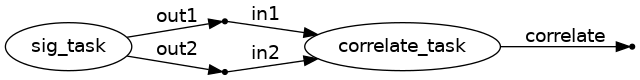

In [3]:
tgraph_corr = TaskGraph.load_taskgraph('./taskgraphs/correlate.gq.yaml')
tgraph_corr.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

If you would like to run via GreenflowLab follow the instructions in the next cell. Running via GreenflowLab will appear as shown in the image below. The output values might differ, because of the random signal generator.

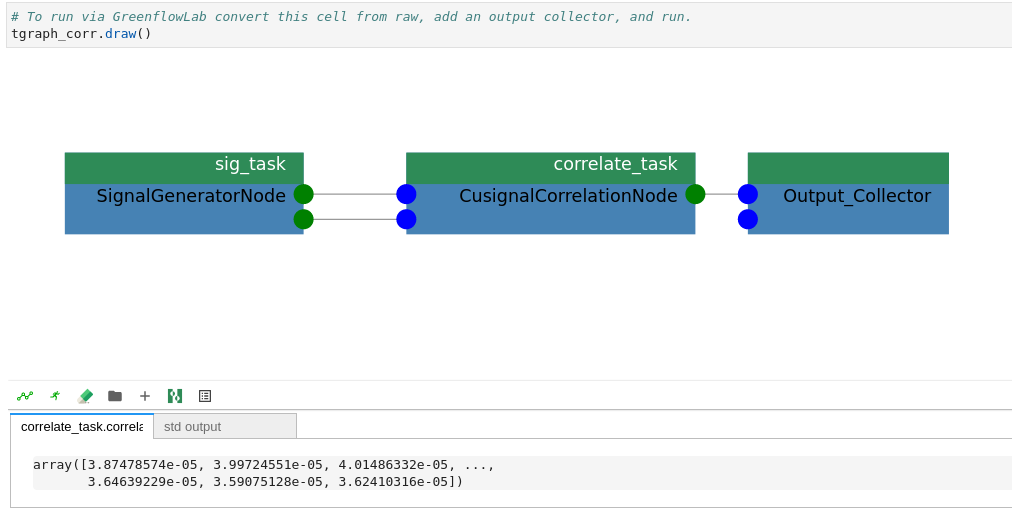

The code to generate signals for correlation is included in the "sig_task" via "pycode" parameter. Feel free to tinker with the "pycode" via GreenflowLab to test other types of signals. Start by drawing the graph `tgraph_corr.draw()` and then click on the nodes to edit their parameters.

In [4]:
tgraph_corr.build()
gensig_code = tgraph_corr['sig_task'].conf.get('pycode')
print('# PyCode to generate output for sig_task\n{}'.format(gensig_code))

# PyCode to generate output for sig_task
import cupy as cp

sig = cp.random.rand(int(1e8))
sig_noise = sig + cp.random.randn(len(sig))
sig_corr = cp.ones(128)

myout = {'out1': sig_noise, 'out2': sig_corr}


In [5]:
(corr_gpu, sig_noise, sig_corr) = tgraph_corr.run(
    ['correlate_task.correlate', 'sig_task.out1', 'sig_task.out2'])

The "sig_task" is a place holder to be able to load a signal programmatically. We can use the replace spec to specify "load" and corresponding output ports for the "sig_task". This will avoid re-running "sig_task", and keep the signals consistent for comparison between CPU and GPU. Also, the configuration of the "correlate_task" is changed to "use_cpu" for the CPU runs. This pattern is repeated throughout the notebook.

In [6]:
replace_gpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': sig_noise,
            'out2': sig_corr
        }
    }
}

conf_cpu = tgraph_corr['correlate_task'].conf.copy()
conf_cpu.update({'use_cpu': True})
replace_cpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': sig_noise.get(),
            'out2': sig_corr.get()
        }
    },
    'correlate_task': {
        TaskSpecSchema.conf: conf_cpu
    }
}

In [7]:
(corr_cpu,) = tgraph_corr.run(['correlate_task.correlate'], replace=replace_cpu)

In [8]:
print('CORR GPU: {}\nCORR CPU: {}'.format(corr_gpu, corr_cpu))
cptest.assert_array_almost_equal(corr_gpu, corr_cpu)

CORR GPU: [2.99128918e-05 3.10918362e-05 3.08941328e-05 ... 3.88921964e-05
 3.88443687e-05 3.83087120e-05]
CORR CPU: [2.99128918e-05 3.10918362e-05 3.08941328e-05 ... 3.88921964e-05
 3.88443687e-05 3.83087120e-05]


In [9]:
gpu_time = %timeit -o (corr_gpu,) = tgraph_corr.run(['correlate_task.correlate'], replace=replace_gpu)

201 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
cpu_time = %timeit -o (corr_cpu,) = tgraph_corr.run(['correlate_task.correlate'], replace=replace_cpu)

3.72 s ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 18.6x


## Convolve

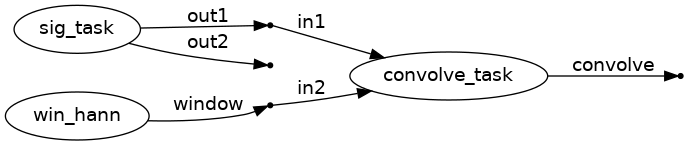

In [12]:
tgraph_conv = TaskGraph.load_taskgraph('./taskgraphs/convolve.gq.yaml')
tgraph_conv.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

In [13]:
tgraph_conv.build()
gensig_code = tgraph_conv['sig_task'].conf.get('pycode')
print('# PyCode to generate output for sig_task\n{}'.format(gensig_code))

# PyCode to generate output for sig_task
import cupy as cp
sig = cp.random.rand(int(1e8))
myout = {'out1': sig}


In [14]:
(conv_gpu, sig) = tgraph_conv.run(['convolve_task.convolve', 'sig_task.out1'])

In [15]:
replace_gpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': sig
        }
    }
}

conf_cpu = {
    'convolve_task': tgraph_conv['convolve_task'].conf.copy(),
    'win_hann': tgraph_conv['win_hann'].conf.copy()
}
conf_cpu['convolve_task'].update({'use_cpu': True})
conf_cpu['win_hann'].update({'use_cpu': True})
replace_cpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': sig.get()
        }
    },
    'win_hann': {
        TaskSpecSchema.conf: conf_cpu['win_hann']
    },
    'convolve_task': {
        TaskSpecSchema.conf: conf_cpu['convolve_task']
    }
}

In [16]:
(conv_cpu,) = tgraph_conv.run(['convolve_task.convolve'], replace=replace_cpu)

In [17]:
print('CONV GPU: {}\nCONV CPU: {}'.format(conv_gpu, conv_cpu))
cptest.assert_array_almost_equal(conv_gpu, conv_cpu)

CONV GPU: [0.24874733 0.24976785 0.25078853 ... 0.25811188 0.25710866 0.25610544]
CONV CPU: [0.24874733 0.24976785 0.25078853 ... 0.25811188 0.25710866 0.25610544]


In [18]:
gpu_time = %timeit -o (conv_gpu,) = tgraph_conv.run(['convolve_task.convolve'], replace=replace_gpu)

201 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
cpu_time = %timeit -o (conv_cpu,) = tgraph_conv.run(['convolve_task.convolve'], replace=replace_cpu)

15.2 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 75.8x


## Convolution using the FFT Method

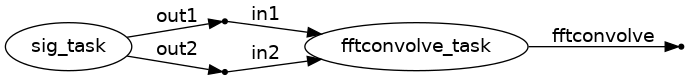

In [21]:
tgraph_fftconv = TaskGraph.load_taskgraph('./taskgraphs/fftconvolve.gq.yaml')
tgraph_fftconv.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

In [22]:
tgraph_fftconv.build()
gensig_code = tgraph_fftconv['sig_task'].conf.get('pycode')
print('# PyCode to generate output for sig_task\n{}'.format(gensig_code))

# PyCode to generate output for sig_task
import cupy as cp
gsig = cp.random.randn(int(1e8))
gsig_reverse = gsig[::-1]
myout = {'out1': gsig, 'out2': gsig_reverse}


In [23]:
(gautocorr, gsig, gsig_reverse) = tgraph_fftconv.run(
    ['fftconvolve_task.fftconvolve', 'sig_task.out1', 'sig_task.out2'])

In [24]:
replace_gpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': gsig,
            'out2': gsig_reverse
        }
    }
}

conf_cpu = tgraph_fftconv['fftconvolve_task'].conf.copy()
conf_cpu.update({'use_cpu': True})
replace_cpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': gsig.get(),
            'out2': gsig_reverse.get()
        }
    },
    'fftconvolve_task': {
        TaskSpecSchema.conf: conf_cpu
    }
}

In [25]:
(cautocorr,) = tgraph_fftconv.run(['fftconvolve_task.fftconvolve'], replace=replace_cpu)

In [26]:
print('AUTOCORR GPU: {}\nAUTOCORR CPU: {}'.format(gautocorr, cautocorr))
cptest.assert_array_almost_equal(gautocorr, cautocorr)

AUTOCORR GPU: [-1.38440037 -1.4631458   0.00953183 ...  0.00953183 -1.4631458
 -1.38440037]
AUTOCORR CPU: [-1.38440037 -1.4631458   0.00953183 ...  0.00953183 -1.4631458
 -1.38440037]


In [27]:
# Clean up memory. FFTconvolve seems to use a lot of GPU memory.
import gc

try:
    del corr_gpu
except Exception:
    pass

try:
    del conv_gpu
except Exception:
    pass

try:
    del gautocorr
except Exception:
    pass

gc.collect()

92

In [28]:
gpu_time = %timeit -o (gautocorr,) = tgraph_fftconv.run(['fftconvolve_task.fftconvolve'], replace=replace_gpu)

415 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
cpu_time = %timeit -o (cautocorr,) = tgraph_fftconv.run(['fftconvolve_task.fftconvolve'], replace=replace_cpu)

24.9 s ± 681 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 60.0x


## Perform 2-D Convolution and Correlation

### Convolve2d

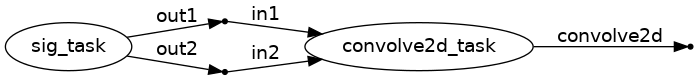

In [31]:
tgraph_conv2d = TaskGraph.load_taskgraph('./taskgraphs/convolve2d.gq.yaml')
tgraph_conv2d.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

In [32]:
tgraph_conv2d.build()
gensig_code = tgraph_conv2d['sig_task'].conf.get('pycode')
print('# PyCode to generate output for sig_task\n{}'.format(gensig_code))

# PyCode to generate output for sig_task
import cupy as cp

gsig = cp.random.rand(int(1e4), int(1e4))
gfilt = cp.random.rand(5,5)

myout = {'out1': gsig, 'out2': gfilt}


In [33]:
(ggrad, gsig, gfilt) = tgraph_conv2d.run(
    ['convolve2d_task.convolve2d', 'sig_task.out1', 'sig_task.out2'])

In [34]:
replace_gpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': gsig,
            'out2': gfilt
        }
    }
}

conf_cpu = tgraph_conv2d['convolve2d_task'].conf.copy()
conf_cpu.update({'use_cpu': True})
replace_cpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': gsig.get(),
            'out2': gfilt.get()
        }
    },
    'convolve2d_task': {
        TaskSpecSchema.conf: conf_cpu
    }
}

In [35]:
(cgrad,) = tgraph_conv2d.run(['convolve2d_task.convolve2d'], replace=replace_cpu)

In [36]:
print('CONV GRAD GPU: {}\nCONV GRAD CPU: {}'.format(ggrad, cgrad))
cptest.assert_array_almost_equal(ggrad, cgrad)

CONV GRAD GPU: [[0.09418511 0.28891615 0.4714031  ... 1.10261787 0.95488512 0.37537047]
 [0.3886122  1.25281041 1.92730512 ... 1.98070304 1.31874051 0.48393504]
 [1.23172081 2.66928131 3.25446231 ... 1.51402005 0.93597158 0.39933616]
 ...
 [1.21542563 2.29897527 2.66578943 ... 2.51846612 1.38937738 1.00662108]
 [0.63316965 1.62170665 2.12106402 ... 2.36277057 1.48810924 1.15980468]
 [0.13636812 0.86435831 0.99863584 ... 1.36198493 0.94709058 0.4818645 ]]
CONV GRAD CPU: [[0.09418511 0.28891615 0.4714031  ... 1.10261787 0.95488512 0.37537047]
 [0.3886122  1.25281041 1.92730512 ... 1.98070304 1.31874051 0.48393504]
 [1.23172081 2.66928131 3.25446231 ... 1.51402005 0.93597158 0.39933616]
 ...
 [1.21542563 2.29897527 2.66578943 ... 2.51846612 1.38937738 1.00662108]
 [0.63316965 1.62170665 2.12106402 ... 2.36277057 1.48810924 1.15980468]
 [0.13636812 0.86435831 0.99863584 ... 1.36198493 0.94709058 0.4818645 ]]


In [37]:
gpu_time = %timeit -o (ggrad,) = tgraph_conv2d.run(['convolve2d_task.convolve2d'], replace=replace_gpu)

59.9 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
cpu_time = %timeit -o (cgrad,) = tgraph_conv2d.run(['convolve2d_task.convolve2d'], replace=replace_cpu)

8.14 s ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 135.9x


### Correlate2d

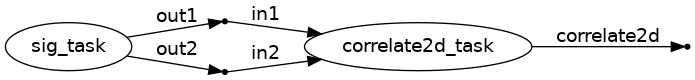

In [40]:
tgraph_corr2d = TaskGraph.load_taskgraph('./taskgraphs/correlate2d.gq.yaml')
tgraph_corr2d.draw(show='ipynb', show_ports=True, pydot_options={'rankdir': 'LR'})

In [41]:
# re-using gsig and gfilt from above convolve2d.
# But need to update configuration for correlate2d_task
tgraph_corr2d.build()
conf_cpu = tgraph_corr2d['correlate2d_task'].conf.copy()
conf_cpu.update({'use_cpu': True})
replace_cpu = {
    'sig_task': {
        TaskSpecSchema.load: {
            'out1': gsig.get(),
            'out2': gfilt.get()
        }
    },
    'correlate2d_task': {
        TaskSpecSchema.conf: conf_cpu
    }
}

In [42]:
(ggrad_corr,) = tgraph_corr2d.run(['correlate2d_task.correlate2d'], replace=replace_gpu)

In [43]:
(cgrad_corr,) = tgraph_corr2d.run(['correlate2d_task.correlate2d'], replace=replace_cpu)

In [44]:
print('CORR GRAD GPU: {}\nCORR GRAD CPU: {}'.format(ggrad_corr, cgrad_corr))
cptest.assert_array_almost_equal(ggrad_corr, cgrad_corr)

CORR GRAD GPU: [[0.64565171 1.11823357 1.70111018 ... 1.14098787 0.76040673 0.11255243]
 [1.42832061 1.89021729 2.67680748 ... 2.09224304 1.34321952 0.49128556]
 [1.61320929 1.8473781  2.33374718 ... 2.64917959 2.00931425 0.88234215]
 ...
 [0.58295659 1.31072564 1.74883323 ... 2.72020388 2.13718772 0.91666393]
 [0.71283266 1.62998312 1.88662539 ... 1.60067698 0.99598523 0.30371569]
 [0.45479753 0.9670105  0.85598757 ... 0.38722271 0.23203973 0.07029248]]
CORR GRAD CPU: [[0.64565171 1.11823357 1.70111018 ... 1.14098787 0.76040673 0.11255243]
 [1.42832061 1.89021729 2.67680748 ... 2.09224304 1.34321952 0.49128556]
 [1.61320929 1.8473781  2.33374718 ... 2.64917959 2.00931425 0.88234215]
 ...
 [0.58295659 1.31072564 1.74883323 ... 2.72020388 2.13718772 0.91666393]
 [0.71283266 1.62998312 1.88662539 ... 1.60067698 0.99598523 0.30371569]
 [0.45479753 0.9670105  0.85598757 ... 0.38722271 0.23203973 0.07029248]]


In [45]:
gpu_time = %timeit -o (ggrad_corr, ) = tgraph_corr2d.run(['correlate2d_task.correlate2d'], replace=replace_gpu)

59.9 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
cpu_time = %timeit -o (cgrad_corr, ) = tgraph_corr2d.run(['correlate2d_task.correlate2d'], replace=replace_cpu)

8.19 s ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
print('SPEEDUP: {}x'.format(round(cpu_time.average / gpu_time.average, 1)))

SPEEDUP: 136.6x
